In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.3 MB/s eta 0:00:00


In [2]:
# -*- coding: utf-8 -*-
"""
R_001_Research_Project__
|
R_001_multiclass_text_classification_from_colab_for_5_classes.ipynb
Created on Thu Jan 18 16:30:03 2024
@author: Rochana Obadage
"""

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import pytz
import re
import argparse
import sys

2024-02-06 23:43:49.506450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 23:43:53.976481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 23:43:53.984888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 23:44:00.736472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [3]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load the datasets
```for_training.csv```

```

They contain
    context -- text
    label_scored:{ -2, -1, 0, 0.5, 1 }
    labeln:{"O-NR", "P-NR", "Neutral", "Weak", "Strong"}
```t

In [2]:
# !ls
# !pwd

In [4]:
df_dataset = pd.read_csv("dataset/for_training.csv")
df_dataset[df_dataset['label']=='Strong']
# df_dataset[df_dataset['label']=='Weak']
# df_dataset[df_dataset['label']=='Neutral']
# df_dataset[df_dataset['label']=='P-NR']
# df_dataset[df_dataset['label']=='O-NR']

In [19]:
def assign_3_lable(x):
    if x==-2 or x== -1:
        return 'negative'
    elif x==0.5 or x== 1:
        return 'positive'
    else:
        return 'neutral'

df_dataset['3_label'] = df_dataset['label_score'].apply(assign_3_lable)
df_dataset

,context,label_score,label,3_label
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral,neutral
1,The subsequent designs consider multiple negat...,0.0,Neutral,neutral
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral,neutral
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral,neutral
4,The proposed method can be seamlessly implante...,0.5,Weak,positive
...,...,...,...,...
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral,neutral
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral,neutral
1934,The source codes of 6 papers were not executab...,-2.0,O-NR,negative
1935,The success of DL has marked the revisiting of...,0.0,Neutral,neutral


In [21]:
df_dataset[df_dataset['label']=='P-NR']

,context,label_score,label,3_label
581,"As we pointed in Section VI, we cannot be sure...",-1.0,P-NR,negative
958,"Also, [23, 26] used different train/test split...",-1.0,P-NR,negative
996,"(Schreiber et al., 2018) uses a different, non...",-1.0,P-NR,negative
1007,Average time taken for our system for each doc...,-1.0,P-NR,negative
1018,Category Method F-measure Recall Precision PDF...,-1.0,P-NR,negative
1229,"The proposed framework can address also TSR, b...",-1.0,P-NR,negative
1491,We unfortunately could not directly evaluate t...,-1.0,P-NR,negative
1695,Note that LGPMA requires additional\nannotatio...,-1.0,P-NR,negative
1697,"All other methods except EDD (Zhong et al., 20...",-1.0,P-NR,negative
1755,Since LGMPA [13] and CycleCenterNet [11] recov...,-1.0,P-NR,negative


In [22]:
df_dataset[df_dataset['label']=='Neutral']

,context,label_score,label,3_label
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral,neutral
1,The subsequent designs consider multiple negat...,0.0,Neutral,neutral
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral,neutral
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral,neutral
5,The drawbacks of these two types of loss funct...,0.0,Neutral,neutral
...,...,...,...,...
1931,A Jain [125] spatial associations + dynamic pr...,0.0,Neutral,neutral
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral,neutral
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral,neutral
1935,The success of DL has marked the revisiting of...,0.0,Neutral,neutral


In [25]:
df_dataset[df_dataset['label']=='Strong']
df_dataset[df_dataset['label']=='Weak']

,context,label_score,label,3_label
4,The proposed method can be seamlessly implante...,0.5,Weak,positive
14,To further demonstrate the effectiveness of Bi...,0.5,Weak,positive
18,"focusing on the feature fusion [39], [49] with...",0.5,Weak,positive
20,"To improve embedding quality, detaching class-...",0.5,Weak,positive
25,We compared the performance of our likelihood ...,0.5,Weak,positive
...,...,...,...,...
1857,We use FinTabNet [41] dataset to train TOD-Net...,0.5,Weak,positive
1888,"For table extraction, we use our Global Table ...",0.5,Weak,positive
1897,"To begin, we apply our table extraction module...",0.5,Weak,positive
1898,Paper metadata from these sources are harmoniz...,0.5,Weak,positive


In [33]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
df_dataset['target'] = df_dataset["3_label"].map(mapping)
df_dataset

,context,label_score,label,3_label,target
0,"Recently, several losses [18], [24], [25] cons...",0.0,Neutral,neutral,1
1,The subsequent designs consider multiple negat...,0.0,Neutral,neutral,1
2,"the mainstream methods [1], [5], [6], [18], [6...",0.0,Neutral,neutral,1
3,"Accordingly, several works [24], [25] based on...",0.0,Neutral,neutral,1
4,The proposed method can be seamlessly implante...,0.5,Weak,positive,2
...,...,...,...,...,...
1932,A Jain [125] suggests training a deep network ...,0.0,Neutral,neutral,1
1933,[39]12 2021 No name ICDAR PubTabNet ICDAR 2019...,0.0,Neutral,neutral,1
1934,The source codes of 6 papers were not executab...,-2.0,O-NR,negative,0
1935,The success of DL has marked the revisiting of...,0.0,Neutral,neutral,1


In [29]:
mapping_reverse = dict((value,key) for key,value in mapping.items())
mapping_reverse


{0: 'negative', 1: 'neutral', 2: 'positive'}

In [30]:
# label_to_score = {'O-NR':-2, 'P-NR':-1, 'Neutral':0, 'Weak':0.5, 'Strong':1}

In [39]:
# label counts per each category
df_ = df_dataset.groupby('3_label').count()
df_.reset_index()

,3_label,context,label_score,label,target
0,negative,23,23,23,23
1,neutral,1756,1756,1756,1756
2,positive,158,158,158,158


In [38]:
df_dataset.to_csv(r'dataset/1937_dataset_for_3_label_sentiment_test.csv',index=False)

In [ ]:
# print(classification_report(y_test, np.argmax(y_pred, axis=1),target_names= label_to_score.keys()))

In [47]:
df_dataset_neutral = df_dataset[df_dataset['3_label'] =='neutral'].sample(n=35, replace=False)
df_dataset_positive = df_dataset[df_dataset['3_label'] =='positive'].sample(n=35, replace=False)
df_dataset_negative = df_dataset[df_dataset['3_label'] =='negative']

df_balanced = pd.concat([df_dataset_neutral, df_dataset_positive,df_dataset_negative], ignore_index = True)
df_balanced = df_balanced.sample(frac = 1).reset_index(drop=True)
df_balanced
df_balanced.to_csv(r'dataset/1937_dataset_for_3_label_sentiment_test_balanced_93.csv',index=False)

In [16]:
# taking only a portion from '0' and '0.5' to make the classes balanced
df_dataset_o_nr = df_dataset[df_dataset['label'] =='O-NR']
df_dataset_p_nr = df_dataset[df_dataset['label'] =='P-NR']

df_dataset_neutral = df_dataset[df_dataset['label'] =='Neutral'].sample(n=35, replace=False)
df_dataset_weak = df_dataset[df_dataset['label'] =='Weak'].sample(n=35, replace=False)
df_dataset_Strong = df_dataset[df_dataset['label'] =='Strong']


df_balanced = pd.concat([df_dataset_o_nr, df_dataset_p_nr,df_dataset_neutral,df_dataset_weak,df_dataset_Strong], ignore_index = True)
df_balanced.to_csv(r"dataset/for_training_balanced.csv", index=False)

In [17]:
df_b = df_balanced.groupby('label_score').count()
df_b.reset_index()

,label_score,context,label,target
0,-2.0,12,12,12
1,-1.0,11,11,11
2,0.0,35,35,35
3,0.5,35,35,35
4,1.0,19,19,19


In [ ]:
# lable names
print(set(df_dataset['label']))
print(set(df_dataset['label_score']))

{'O-NR', 'Strong', 'P-NR', 'Neutral', 'Weak'}
{0.0, 0.5, 1.0, -1.0, -2.0}


In [36]:
test_size =0.2

df_train, df_test = train_test_split(df_balanced, test_size=0.2,stratify=df_balanced.label.values)

In [37]:
df_1 = df_train.groupby('label_score').count()
df_1.reset_index()

,label_score,context,label,target
0,-2.0,9,9,9
1,-1.0,9,9,9
2,0.0,28,28,28
3,0.5,28,28,28
4,1.0,15,15,15


In [38]:
df_2 = df_test.groupby('label_score').count()
df_2.reset_index()

,label_score,context,label,target
0,-2.0,3,3,3
1,-1.0,2,2,2
2,0.0,7,7,7
3,0.5,7,7,7
4,1.0,4,4,4


In [39]:
df_train.to_csv(r"dataset/train.csv",index=False)
df_test.to_csv(r"dataset/test.csv",index=False)

In [12]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (89, 4)
Training Set Memory Usage = 0.00 MB
Test Set Shape = (23, 4)
Test Set Memory Usage = 0.00 MB


In [13]:
df_train.head()

,context,label_score,label,target
0,The source codes of 6 papers were not executab...,-2.0,O-NR,0
1,Category Method F-measure Recall Precision PDF...,-1.0,P-NR,1
2,This reproducibility study focuses on Antoniak...,1.0,Strong,4
3,"Experimental Results: Now, we present comparis...",0.5,Weak,3
4,We further observe that empty cells account fo...,0.5,Weak,3


In [14]:
df_test.head()

,context,label_score,label,target
0,"As shown in Table 4, the re-implemented SPLERG...",-2.0,O-NR,0
1,"Also based on DGCNN, TabStructNet [36] is prop...",0.0,Neutral,2
2,Table structure recognizer is our own implemen...,0.5,Weak,3
3,Splitting Model Merging Model Performance(Pubt...,0.0,Neutral,2
4,Note that LGPMA requires additional\nannotatio...,-1.0,P-NR,1


# Explore the dataset

In [15]:
df_train["length"] = df_train["context"].apply(lambda x : len(x))
df_test["length"] = df_test["context"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count     89.000000
mean     177.213483
std      112.509845
min       46.000000
25%      106.000000
50%      161.000000
75%      214.000000
max      781.000000
Name: length, dtype: float64

Test Length Stat
count     23.000000
mean     155.173913
std       73.749978
min       38.000000
25%       90.000000
50%      172.000000
75%      211.000000
max      298.000000
Name: length, dtype: float64


# Preprocess the data

In [19]:
from sklearn.model_selection import train_test_split

X = df_train["context"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df_train.label.values)

X_test = df_test["context"]
y_test = df_test["target"]

set(y)

{0, 1, 2, 3, 4}

In [20]:
len(y_train)

80

In [21]:
len(y_val)

9

In [22]:
BATCH_SIZE = 16
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 30 #8
AUTO = tf.data.experimental.AUTOTUNE
NUM_TRAINING_EXAMPLES

89

In [23]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=512,
                                                                   )
# preprocessor_4_tweets
# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=5)

classifier.summary()

Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 5)                 │       3,845 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,957,317 (255.42 MB)

 Trainable params: 66,957,317 (255.42 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [5]:
classifier.fit(x=X_train, y=y_train, batch_size=2)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"],
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                        )


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


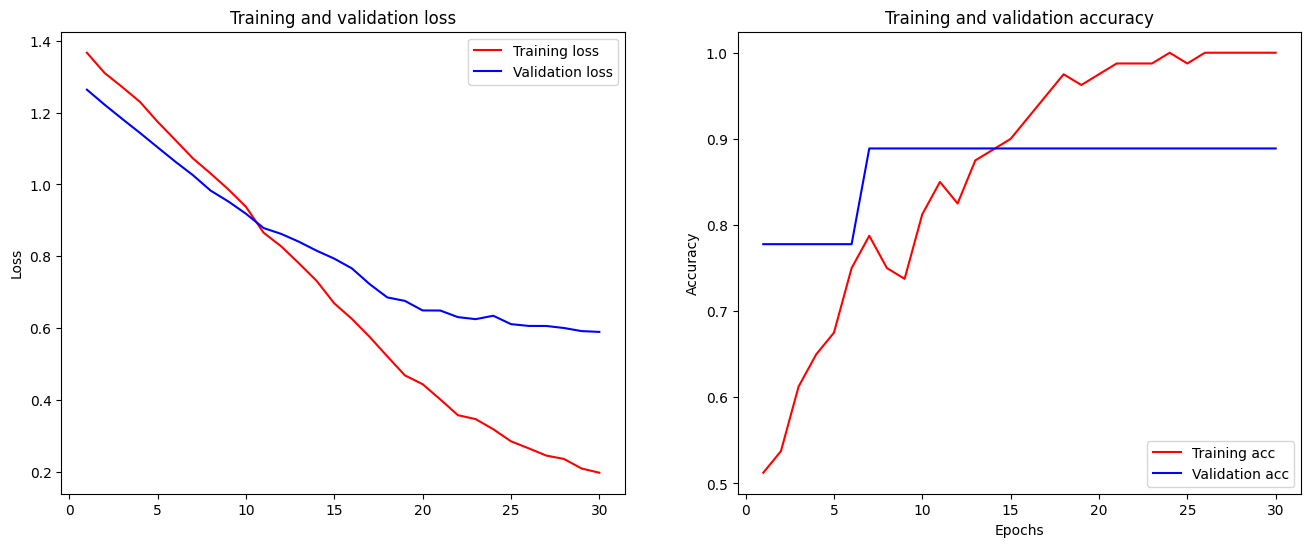

In [70]:
from matplotlib import pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16, 6))
fig.tight_layout()

plt.subplot(1, 2, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [ ]:
# !pip install tensorflow-addons==0.16.1

In [34]:
dataset_name = 'lemos_R_001_label_predictor_004_30ep'
saved_model_path = './{}_bert.keras'.format(dataset_name.replace('/', '_'))

classifier.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/task.py:47: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: 

In [25]:
model_path = 'lemos_R_001_label_predictor_005_30ep_bert.keras'

reloaded_model_22 = keras.models.load_model(model_path)

/home/oruma001/envs/cs834_project/lib/python3.10/site-packages/keras_core/src/saving/serialization_lib.py:713: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/home/oruma001/envs/cs834_project/lib/python3.10/site-packages/keras_core/src/saving/saving_lib.py:347: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 210 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


# Predictions

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_true, y_preds, labels=None, type_="Test",normalize_="true"):
  cm = confusion_matrix(y_true, y_preds)
  cm = confusion_matrix(y_true, y_preds, normalize=normalize_)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title(f"{type_} confusion matrix")
  plt.show()


# plot_confusion_matrix(valid_pred, valid_df['label'].to_numpy(),labels=label_names)

In [36]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df_train.label.values)
# stratify=df_balanced.label.values
# X_test = df_test["context"]
# y_test = df_test["target"]

y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)
y_pred_test = classifier.predict(X_test)


1/1 [==============================] - 3s 3s/step


# training : confusion-matrix

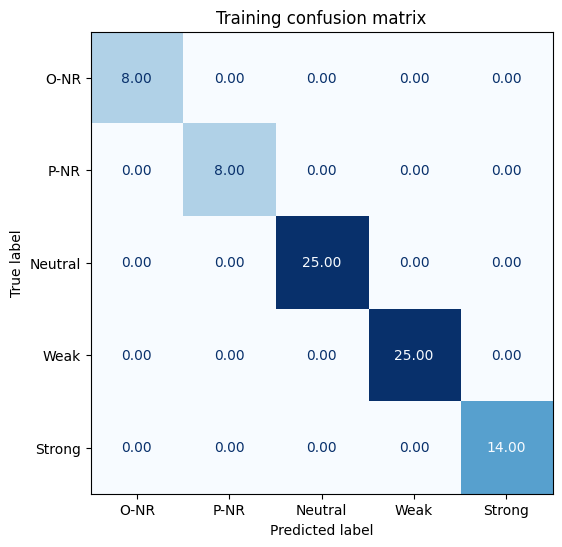

In [66]:
# training
plot_confusion_matrix(y_train, np.argmax(y_pred_train, axis=1),labels= label_to_score.keys(),type_="Training",normalize_=None)  #normalize_="true" -- default

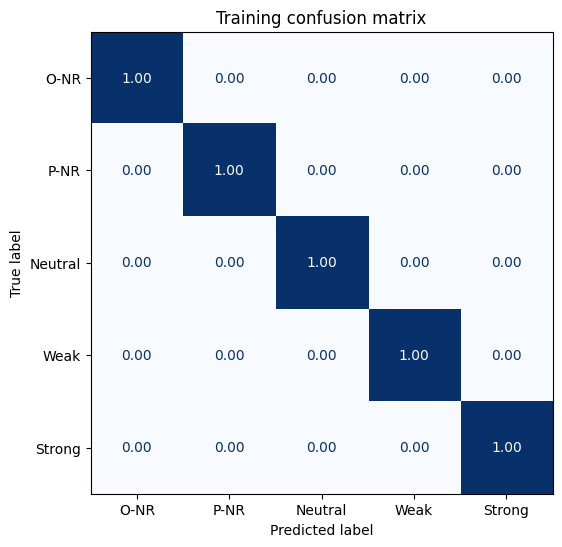

In [67]:
# training
plot_confusion_matrix(y_train, np.argmax(y_pred_train, axis=1),labels= label_to_score.keys(),type_="Training")

In [40]:
from sklearn.metrics import classification_report
print('classifiation report : Training')
print(classification_report(y_train, np.argmax(y_pred_train, axis=1),target_names= label_to_score.keys()))

classifiation report : Training
              precision    recall  f1-score   support

        O-NR       1.00      1.00      1.00         8
        P-NR       1.00      1.00      1.00         8
     Neutral       1.00      1.00      1.00        25
        Weak       1.00      1.00      1.00        25
      Strong       1.00      1.00      1.00        14

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



# validation : confusion-matrix

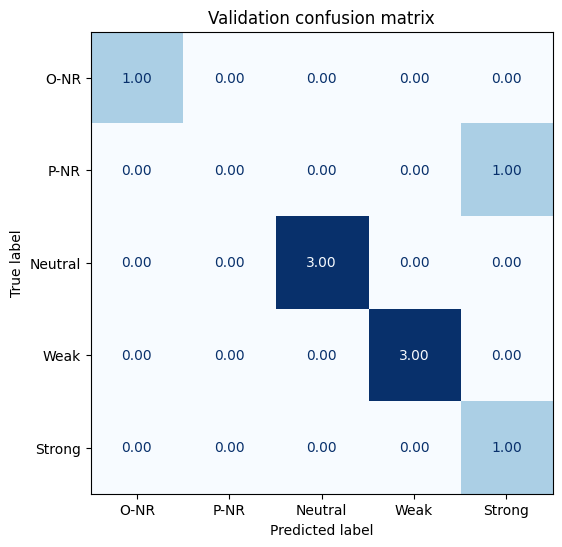

In [63]:
# validation
plot_confusion_matrix(y_val, np.argmax(y_pred_val, axis=1),labels= label_to_score.keys(),type_="Validation")

In [42]:
from sklearn.metrics import classification_report
print('classifiation report: Validation')
print(classification_report(y_val, np.argmax(y_pred_val, axis=1),target_names= label_to_score.keys()))

classifiation report: Validation
              precision    recall  f1-score   support

        O-NR       1.00      1.00      1.00         1
        P-NR       0.00      0.00      0.00         1
     Neutral       1.00      1.00      1.00         3
        Weak       1.00      1.00      1.00         3
      Strong       0.50      1.00      0.67         1

    accuracy                           0.89         9
   macro avg       0.70      0.80      0.73         9
weighted avg       0.83      0.89      0.85         9



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Testing : confusion-matrix

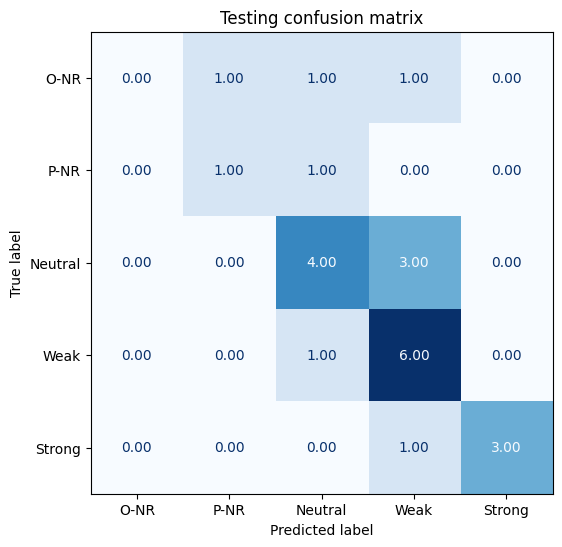

In [61]:
# Testing
plot_confusion_matrix(y_test, np.argmax(y_pred_test, axis=1),labels= label_to_score.keys(),type_="Testing")

In [44]:
from sklearn.metrics import classification_report
print('classifiation report: Testing')
print(classification_report(y_test, np.argmax(y_pred_test, axis=1),target_names= label_to_score.keys()))

classifiation report: Testing
              precision    recall  f1-score   support

        O-NR       0.00      0.00      0.00         3
        P-NR       0.50      0.50      0.50         2
     Neutral       0.57      0.57      0.57         7
        Weak       0.55      0.86      0.67         7
      Strong       1.00      0.75      0.86         4

    accuracy                           0.61        23
   macro avg       0.52      0.54      0.52        23
weighted avg       0.56      0.61      0.57        23



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
import glob
label_file_list = [i for i in glob.glob("automated_labelling/*.csv")]

label_file_list
df_test_1 = pd.read_csv(label_file_list[0])

In [28]:
label_file_list = [i for i in glob.glob("automated_labelling/*.csv")]

label_file_list
df_test_1 = pd.read_csv(label_file_list[12])

for file_ in label_file_list:
    filename = file_.replace("automated_labelling/","")
    print(filename)

RS_083_MLRC_2021_38.csv
RS_033_MLRC_2022_33.csv
RS_087_MLRC_2021_42.csv
RS_005_MLRC_2022_05.csv
RS_084_MLRC_2021_39.csv
RS_019_MLRC_2022_19.csv
RS_079_MLRC_2021_34.csv
RS_052_MLRC_2021_07.csv
RS_064_MLRC_2021_19.csv
RS_093_MLRC_2021_48.csv
RS_073_MLRC_2021_28.csv
RS_035_MLRC_2022_35.csv
RS_096_MLRC_2020_03.csv
RS_042_MLRC_2022_42.csv
RS_045_MLRC_2022_45.csv
RS_068_MLRC_2021_23.csv
RS_006_MLRC_2022_06.csv
RS_097_MLRC_2020_04.csv
RS_072_MLRC_2021_27.csv
RS_065_MLRC_2021_20.csv
RS_089_MLRC_2021_44.csv
RS_059_MLRC_2021_14.csv
RS_003_MLRC_2022_03.csv
RS_077_MLRC_2021_32.csv
RS_026_MLRC_2022_26.csv
RS_015_MLRC_2022_15.csv
RS_067_MLRC_2021_22.csv
RS_063_MLRC_2021_18.csv
RS_048_MLRC_2021_03.csv
RS_054_MLRC_2021_09.csv
RS_022_MLRC_2022_22.csv
RS_032_MLRC_2022_32.csv
RS_047_MLRC_2021_02.csv
RS_007_MLRC_2022_07.csv
RS_030_MLRC_2022_30.csv
RS_012_MLRC_2022_12.csv
RS_014_MLRC_2022_14.csv
RS_099_MLRC_2020_06.csv
RS_056_MLRC_2021_11.csv
RS_078_MLRC_2021_33.csv
RS_020_MLRC_2022_20.csv
RS_060_MLRC_2021

In [29]:
df_test_1

,text,label_score,label
0,These activation functions were proved to be a...,NaN,NaN
1,The activation functions x+ 1 a sin (2)(ax) -c...,NaN,NaN
2,The first two layers are provided with the Sna...,NaN,NaN
3,"Furthermore, we replace leaky ReLU activation ...",NaN,NaN
4,We also substitute the MSD discriminator [14] ...,NaN,NaN
...,...,...,...
90,"In fact, previous works [141, 161] have shown ...",NaN,NaN
91,The first MLP contains 9 fully-connected Snake...,NaN,NaN
92,Since ReLU activation function has been proven...,NaN,NaN
93,"Unfortunately, this approach is not guaranteed...",NaN,NaN


In [55]:
df_test_2 = pd.read_csv("dataset/test.csv")

In [56]:
df_test_2

,context,label_score,label,target
0,"As shown in Table 4, the re-implemented SPLERG...",-2.0,O-NR,0
1,"Also based on DGCNN, TabStructNet [36] is prop...",0.0,Neutral,2
2,Table structure recognizer is our own implemen...,0.5,Weak,3
3,Splitting Model Merging Model Performance(Pubt...,0.0,Neutral,2
4,Note that LGPMA requires additional\nannotatio...,-1.0,P-NR,1
5,[28] 2019 DeeptabSTR ICDAR TabStructDB ICDAR 2...,0.0,Neutral,2
6,In this section we analyze two popular benchma...,0.5,Weak,3
7,We use FinTabNet [41] dataset for training.,0.5,Weak,3
8,"Inspired by the analysis, we designed a simple...",1.0,Strong,4
9,Secondly we pick the best hyper-parameters fou...,0.0,Neutral,2


In [7]:
predictions_df = df_test_1.copy()
predictions_df['target_predict'] = 0
x_test_series = predictions_df['text']

predictions = reloaded_model_22.predict(x_test_series)
predictions_df["target_predict"] = np.argmax(predictions, axis=1)

mapping = {'O-NR':0, 'P-NR':1, 'Neutral':2, 'Weak':3, 'Strong':4}
mapping_reverse = {0: 'O-NR', 1: 'P-NR', 2: 'Neutral', 3: 'Weak', 4: 'Strong'}
label_to_score = {'O-NR': -2, 'P-NR': -1, 'Neutral': 0, 'Weak': 0.5, 'Strong': 1}

predictions_df['label'] = predictions_df["target_predict"].map(mapping_reverse)
predictions_df['label_score'] = predictions_df["label"].map(label_to_score)

predictions_df

filename = 'dataset/'+ file_.replace("automated_labelling/","")

predictions_df.to_csv(filename,index=False)

In [ ]:
filename = 'dataset/'+ file_.replace("automated_labelling/","")

predictions_df.to_csv(filename,index=False)

In [43]:
zero_citation_list = ["RS_007","RS_070"]

label_file_list = [i for i in glob.glob("automated_labelling/*.csv") if i.replace("automated_labelling/","")[:6] not in zero_citation_list]
len(label_file_list)

143

In [45]:
zero_citation_list = ["RS_007","RS_070","RS_146"]
label_file_list = [i for i in glob.glob("automated_labelling/*.csv") if i.replace("automated_labelling/","")[:6] not in zero_citation_list]

print(len(label_file_list))
# df_test_1 = pd.read_csv(label_file_list[12])

for file_ in label_file_list:
    df_ = pd.read_csv(file_)
    print(len(df_))

    predictions_df = df_.copy()

    predictions_df['target_predict'] = 0
    x_test_series = predictions_df['text']

    predictions = reloaded_model_22.predict(x_test_series) 
    
    predictions_df["target_predict"] = np.argmax(predictions, axis=1)    
    
    mapping = {'O-NR':0, 'P-NR':1, 'Neutral':2, 'Weak':3, 'Strong':4}
    mapping_reverse = {0: 'O-NR', 1: 'P-NR', 2: 'Neutral', 3: 'Weak', 4: 'Strong'}
    label_to_score = {'O-NR': -2, 'P-NR': -1, 'Neutral': 0, 'Weak': 0.5, 'Strong': 1}
    
    predictions_df['label'] = predictions_df["target_predict"].map(mapping_reverse)
    predictions_df['label_score'] = predictions_df["label"].map(label_to_score)
       
    predictions_df.to_csv(filename,index=False)
    
    filename = file_.replace("automated_labelling/","")

    full_filename = os.path.join("labelled", filename)
    print(full_filename)

    print("\n\n\n")
    print(predictions_df)
    
    predictions_df.to_csv(full_filename,index=False)
    print(full_filename + ' saved')

142
automated_labelling/RS_083_MLRC_2021_38.csv
15
labelled/RS_083_MLRC_2021_38.csv
automated_labelling/RS_116_MLRC_2020_23.csv
51
labelled/RS_116_MLRC_2020_23.csv
automated_labelling/RS_033_MLRC_2022_33.csv
9
labelled/RS_033_MLRC_2022_33.csv
automated_labelling/RS_087_MLRC_2021_42.csv
113
labelled/RS_087_MLRC_2021_42.csv
automated_labelling/RS_005_MLRC_2022_05.csv
10
labelled/RS_005_MLRC_2022_05.csv
automated_labelling/RS_084_MLRC_2021_39.csv
255
labelled/RS_084_MLRC_2021_39.csv
automated_labelling/RS_148_ICDAR_2018_15.csv
4
labelled/RS_148_ICDAR_2018_15.csv
automated_labelling/RS_019_MLRC_2022_19.csv
19
labelled/RS_019_MLRC_2022_19.csv
automated_labelling/RS_079_MLRC_2021_34.csv
52
labelled/RS_079_MLRC_2021_34.csv
automated_labelling/RS_145_ICDAR_2018_12.csv
90
labelled/RS_145_ICDAR_2018_12.csv
automated_labelling/RS_052_MLRC_2021_07.csv
40
labelled/RS_052_MLRC_2021_07.csv
automated_labelling/RS_064_MLRC_2021_19.csv
73
labelled/RS_064_MLRC_2021_19.csv
automated_labelling/RS_093_MLRC_